In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score, classification_report
import matplotlib.pyplot as plt

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

!pip install optuna

from sklearn import preprocessing
import requests
import os
!pip install python-igraph
import networkx as nx
from xgboost import XGBClassifier
import igraph as ig
import sys
from sklearn.utils import compute_sample_weight


In [3]:

data = pd.read_csv("SAML-D_sampled_data.csv") 


data.tail()


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
2999995,23:01:55,2023-06-03,6465028610,2172225510,155695.31,UK pounds,Dirham,UK,UAE,Cross-border,1,Single_large
2999996,08:14:29,2023-05-10,9634559331,8020264563,2481.04,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
2999997,22:05:45,2022-12-15,1240988490,4597902876,3119.80,UK pounds,Yen,UK,UK,Cheque,1,Structuring
2999998,22:17:46,2022-10-18,6770601554,6128626942,76.65,UK pounds,Naira,UK,Nigeria,Cash Withdrawal,1,Cash_Withdrawal
2999999,05:46:53,2023-04-05,8424086459,3934928194,4284.21,UK pounds,Albanian lek,UK,Albania,Cross-border,1,Deposit-Send


In [4]:

data['Hour'] = pd.to_datetime(data['Time']).dt.hour

data['Date_Year'] = pd.to_datetime(data['Date']).dt.year
data['Date_Month'] = pd.to_datetime(data['Date']).dt.month
data['Date_Day'] = pd.to_datetime(data['Date']).dt.day

data.drop(columns=['Laundering_type'], inplace=True)
data.drop(columns=['Time', 'Date'], inplace=True)


for col in ['Sender_account', 'Receiver_account']:
    data[col] = data[col].astype(str)
data.dropna(subset=["Sender_account", "Receiver_account"], inplace=True)

# Netwerk features
G = nx.DiGraph()
edges = list(zip(data["Sender_account"], data["Receiver_account"], data["Amount"]))
G.add_weighted_edges_from(edges)

G_ig = ig.Graph.TupleList(edges, directed=True)
data["degree_centrality"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# time features
data["rolling_24h_amount"] = data.groupby("Sender_account")["Amount"]\
                                 .rolling(50).sum().reset_index(0, drop=True).fillna(0)
data["transaction_count"] = data.groupby("Sender_account")["Amount"].transform("count")

# Feature selection
features = data.drop(columns=[
    'Is_laundering',
    'rolling_24h_amount',
    'Sender_bank_location',
    'Payment_currency',
    'Received_currency'
]).copy()

# add new features manual
features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]
features.drop(columns=['Date_Year', 'Date_Month'], inplace=True, errors='ignore')

# Target
target = data['Is_laundering']






In [7]:
# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target, random_state=42
)

#  Train/validation split within training set
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# categorical encoding
categorical_cols = [
    'Sender_account', 'Receiver_account', 
    'Payment_type', 'Date_Day', 
    'Receiver_bank_location'   
]

encoders = {}
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    
    combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    
    # Fit on the combined
    le.fit(combined)
    
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    encoders[col] = le  


#  scale numerical features
numerical_cols = ['Hour', 'Amount']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


<ipython-input-7-c2950c204683>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.transform(X_train[col].astype(str))
<ipython-input-7-c2950c204683>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = le.transform(X_val[col].astype(str))
<ipython-input-7-c2950c204683>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Train shape: (1680000, 11)
Validation shape: (420000, 11)
Test shape: (900000, 11)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [8]:
print(X_test)

         Sender_account  Receiver_account    Amount  Receiver_bank_location  \
1002978          116314            160958 -0.254320                      16   
2020803          248365             22234 -0.327182                      16   
42581            249397            288807 -0.272588                      16   
1739854          159199            204510  0.066471                      16   
396445           241747            523346  0.684571                      16   
...                 ...               ...       ...                     ...   
1672801          254985            545425 -0.063109                      16   
2798920          190240            334258  0.579857                      16   
388010           114926            160276 -0.123645                      16   
2315930           63818            518057 -0.344419                      16   
2988217          103914            283630 -0.150035                      16   

         Payment_type      Hour  Date_Day  degree_c

In [29]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
    
    np.random.seed(random_state)

    
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen




y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio=0.5)


In [15]:
#optuna

#def objective(trial):
 #   C = trial.suggest_float("C", 0.01, 100.0, log=True)

#    model = LogisticRegression(
 #       C=C,
  #      penalty='l2',
   #     solver='lbfgs',
    #    class_weight='balanced',
     #   max_iter=1000
   # )

    # Train on PU-labels
#    model.fit(X_train, y_train_pu)


#    y_val_pred = model.predict(X_val)

 #   score = f1_score(y_val_true, y_val_pred)

  #  return score

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=30, timeout=300)

#print("Beste parameters:", study.best_params)
#print("Beste F1-score (CV):", study.best_value)

#Train with beste model
#best_model = LogisticRegression(
 #   C=study.best_params['C'],
  #  penalty='l2',
   # solver='lbfgs',
    #class_weight='balanced',
    #max_iter=1000
#)
#best_model.fit(X_train, y_train_pu)



[I 2025-05-12 13:56:14,089] A new study created in memory with name: no-name-29d8e9fd-b280-4504-a9a6-48549988eb2b
[I 2025-05-12 13:56:22,864] Trial 0 finished with value: 0.003164776111134195 and parameters: {'C': 0.05341892434743389}. Best is trial 0 with value: 0.003164776111134195.
[I 2025-05-12 13:56:30,865] Trial 1 finished with value: 0.003164776111134195 and parameters: {'C': 58.439358370878054}. Best is trial 0 with value: 0.003164776111134195.
[I 2025-05-12 13:56:38,796] Trial 2 finished with value: 0.003164776111134195 and parameters: {'C': 22.69091394338591}. Best is trial 0 with value: 0.003164776111134195.
[I 2025-05-12 13:56:47,044] Trial 3 finished with value: 0.003164776111134195 and parameters: {'C': 4.17148177337621}. Best is trial 0 with value: 0.003164776111134195.
[I 2025-05-12 13:56:55,416] Trial 4 finished with value: 0.003164776111134195 and parameters: {'C': 5.734830085306674}. Best is trial 0 with value: 0.003164776111134195.
[I 2025-05-12 13:57:03,507] Trial 

Beste parameters: {'C': 0.05341892434743389}
Beste F1-score (CV): 0.003164776111134195


LogisticRegression(C=0.05341892434743389, class_weight='balanced',
                   max_iter=1000)

In [9]:
print(X_train.select_dtypes(include='object').columns)


Index(['Receiver_bank_location'], dtype='object')


In [30]:
#Beste parameters: {'C': 0.05341892434743389}
# Train with the beste model (optuna values)
best_model = LogisticRegression(
    C=0.05341892434743389,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000
)
best_model.fit(X_train, y_train_pu)

LogisticRegression(C=0.05341892434743389, class_weight='balanced',
                   max_iter=1000)

In [31]:
y_probs = best_model.predict_proba(X_test)[:, 1]  


thresholds = np.arange(0.0, 1.05, 0.05)

# calcultaing F1-scores en PR AUC scores for different thresholds
best_threshold = 0
best_f1 = 0
f1_scores = []
pr_auc_scores = []

for threshold in thresholds:
    y_pred_custom = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_custom)
    pr_auc = average_precision_score(y_test, y_pred_custom)
    f1_scores.append(f1)
    pr_auc_scores.append(pr_auc)
    
    # Check whether this threshold is better than previous best
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold


Beste threshold: 0.73
Accuracy: 0.9659666666666666
Precision: 0.006743961994618119
Recall: 0.21711229946524063
F1-score: 0.013081582678180178
ROC AUC: 0.7181469304816404
PR AUC (beste threshold): 0.004267455237043232


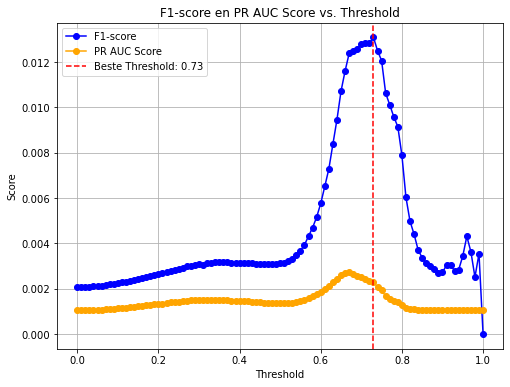

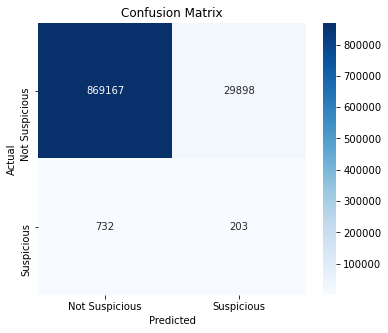

In [32]:
y_probs = best_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
pr_auc_scores = [average_precision_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_best = (y_probs >= best_threshold).astype(int)


# Evaluation with best threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_probs)
pr_auc_best = average_precision_score(y_test, y_probs)

# Results
print(f"Beste threshold: {best_threshold}")
print(f"Accuracy: {accuracy_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1-score: {f1_best}")
print(f"ROC AUC: {roc_auc_best}")
print(f"PR AUC (beste threshold): {pr_auc_best}")

# F1 en PR AUC versus thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label="F1-score", color='blue')
plt.plot(thresholds, pr_auc_scores, marker='o', linestyle='-', label="PR AUC Score", color='orange')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Beste Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1-score en PR AUC Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


# Confusion matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
np.save("preds_LR.npy", y_pred_best)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_probs)
auc_pu = roc_auc_score(y_test, y_probs)

np.savez("roc_LR.npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_probs)